In [91]:
from datetime import datetime
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, GRU, Dense,Flatten,Dropout,Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.losses import mean_squared_error
import mlflow.tensorflow
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [92]:
def create_sequences(dataset, timesteps=1, dropNa=True):
    """Converts time series into a data set for supervised machine learning models"""
    # drop row's which include Nan elements (data preprocessing)
    df = pd.DataFrame(dataset)
    if dropNa:
        df.dropna(inplace=True)
    dataset = df.values
    # create x and y out of dataset
    dataX, dataY = [], []
    for i in range(len(dataset)):
        endIdx = i + timesteps
        # stop if reached the end of dataset
        if endIdx + 1 > len(dataset):
            break
        dataX.append(dataset[i:endIdx, :])
        dataY.append(dataset[endIdx, :])
    return np.array(dataX), np.array(dataY)

In [93]:
def test_train(datasetsize, testsize, shuffle=True):
    """Returns two dataset to train and test machine learning models"""
    if shuffle:
        ntest = int(np.ceil(testsize * datasetsize))
        idx = np.arange(0, datasetsize)
        np.random.shuffle(idx)
        train_index = idx[ntest:]
        test_index = idx[:ntest]
        return train_index, test_index
    else:
        #TODO: Check datasplitting use int(np.ceil(testsize * datasetsize))
        ntest = int(np.ceil(testsize * datasetsize))
        idx = np.arange(0, datasetsize)
        test_index = idx[datasetsize - ntest:]
        train_index = idx[:datasetsize - ntest]
        return train_index, test_index

In [94]:
def LSTM_model():
    model = ks.Sequential()
    model.add(ks.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(ks.layers.LSTM(units=50, return_sequences=False))
    model.add(ks.layers.Dense(units=25))
    model.add(ks.layers.Dense(units=1))
    model.compile(optimizer='adam',
              loss=mean_squared_error,
              metrics=['accuracy'])
    return model

In [95]:
def build_model_cnn(n_steps,n_feats,n_fore=1):
    model = Sequential()
    model.add(Conv1D(filters=50, kernel_size=3, activation='relu',input_shape=(n_steps,n_feats)))
    #model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    #model.add(Dropout(0.20))
    #model.add(Dense(128, activation='relu'))
    #model.add(Dense(32, activation='relu'))
    model.add(Dense(n_fore, activation='linear'))
    model.compile(optimizer='adam',
                  loss=mean_squared_error,
                  metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
                 )
    return model

# Just to test the system

In [ ]:
# Create a test Sequence
seq = pd.DataFrame([[1,101],[2,102],[3,103],[4,104],[5,105],[6,106],[7,107],[8,108],[9,109],[10,110]])
n_steps = 5
dropNan = False
shuffle = True

In [ ]:
X_Data, y_Data = create_sequences(seq, n_steps, dropNan)

In [ ]:
train_index, test_index = test_train(len(X_Data), 0.33, shuffle)
print(train_index,test_index)

In [ ]:
# rename the columns of y_Data
X_train = X_Data[train_index]
X_test = X_Data[test_index]
y_train = y_Data[train_index]
y_test = y_Data[test_index]

In [ ]:
n_feats = X_train.shape[2]
n_fore = seq.shape[1]
print(n_steps,n_feats,n_fore)

In [ ]:
model = build_model_cnn(n_steps,n_feats,n_fore)
model.summary()

history = model.fit(
    X_train,
    y_train,
    batch_size=10,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[
        EarlyStopping(patience=10),
    ],
)

In [ ]:
# summarize history for accuracy
plt.figure()
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mean suqared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model mean absolute percentage error')
plt.ylabel('mean absolute percentage error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['cosine_proximity'])
plt.plot(history.history['val_cosine_proximity'])
plt.title('model cosine proximity')
plt.ylabel('cosine proximity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(y_train[0])
model.predict(np.reshape(X_train[0], (1,X_train[0].shape[0], X_train[0].shape[1])))

In [ ]:
predictions = model.predict(X_test)
print(predictions)

In [ ]:
# Visualize the data
plt.figure()
plt.scatter(predictions,y_test)
plt.grid(True)
plt.title("title")
plt.xlabel("x-label")
plt.ylabel("y-label")
plt.show()

# Real data

In [96]:
dataset = pd.read_csv('../data/Forecast Data/dataset.csv')
dataset['DATE'] = [datetime.strptime(date, '%Y-%m-%d') for date in dataset['DATE']]
dataset = dataset.set_index('DATE')
dataset = dataset[:-3]

In [97]:
# Throw an exception when containing NaN values
if dataset.isnull().sum().sum() != 0:
    raise Exception("The dataset contains NaN values")

In [98]:
n_steps = 5
dropNan = False
shuffle = True

In [99]:
X_Data, y_Data_comp = create_sequences(dataset, n_steps, dropNan)
# Drop the featurs that we don't want to predict
y_Data = y_Data_comp[:,:28]

In [100]:
train_index, test_index = test_train(len(X_Data), 0.33, shuffle)

In [101]:
# rename the columns of y_Data
X_train = X_Data[train_index]
X_test = X_Data[test_index]
y_train = y_Data[train_index]
y_test = y_Data[test_index]

In [102]:
n_feats = X_train.shape[2]
n_fore = y_Data.shape[1]
print(n_steps,n_feats,n_fore)

5 29 28


In [103]:
model = build_model_cnn(n_steps,n_feats,n_fore)
model.summary()

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[
        EarlyStopping(patience=10),
    ],
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 3, 50)             4400      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 50)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 28)                1428      
Total params: 5,828
Trainable params: 5,828
Non-trainable params: 0
_________________________________________________________________
Train on 159 samples, validate on 79 samples
Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0646 - mean_absolute_percentage_error: 3632652.5000 - cosine_proximit

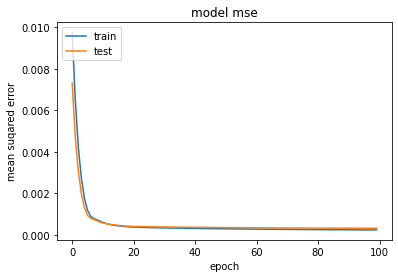

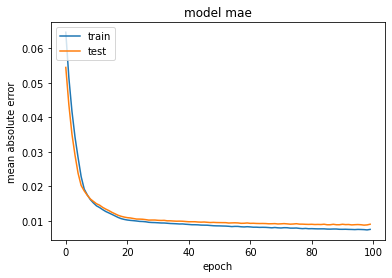

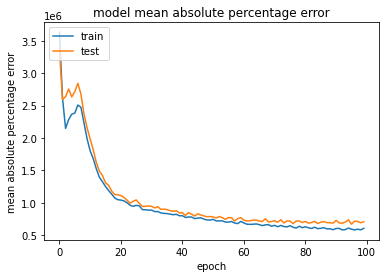

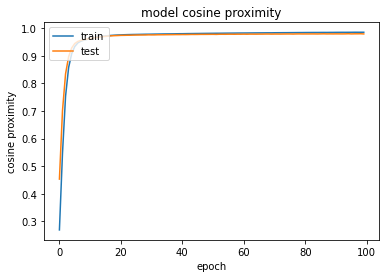

In [104]:
# summarize history for accuracy
plt.figure()
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mean suqared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model mean absolute percentage error')
plt.ylabel('mean absolute percentage error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['cosine_proximity'])
plt.plot(history.history['val_cosine_proximity'])
plt.title('model cosine proximity')
plt.ylabel('cosine proximity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [105]:
print(y_train[0])
model.predict(np.reshape(X_train[0], (1,X_train[0].shape[0], X_train[0].shape[1])))

[0.00736857 0.13522446 0.00371248 0.0018442  0.00148796 0.01930255
 0.19982339 0.01685773 0.00740029 0.00470287 0.00460585 0.00690046
 0.00368017 0.01433355 0.00353714 0.00960869 0.04468487 0.00153845
 0.00986744 0.00585068 0.00791237 0.00497748 0.00262958 0.00120955
 0.00197137 0.00485941 0.01387775 0.46023069]


array([[ 0.00685267,  0.16566768,  0.01190649,  0.00175963,  0.00486401,
         0.02239502,  0.19541836,  0.01091529,  0.00278235,  0.00572543,
         0.00561197,  0.00290002,  0.00309935,  0.01353666,  0.00432224,
         0.0136123 ,  0.01486866,  0.01638844,  0.0140532 ,  0.00639699,
        -0.00101244,  0.00817684, -0.00226403,  0.00662706,  0.00496215,
         0.0060941 ,  0.0233455 ,  0.46648097]], dtype=float32)

In [106]:
predictions = model.predict(X_test)
print(predictions)

[[0.0149718  0.02319667 0.02790093 ... 0.00734136 0.03242293 0.38241762]
 [0.00822547 0.17092608 0.0078237  ... 0.00716316 0.00987937 0.4678691 ]
 [0.00897013 0.17162465 0.01114363 ... 0.00658646 0.01341332 0.46661222]
 ...
 [0.00974759 0.15812746 0.01200175 ... 0.00387855 0.02664655 0.44568354]
 [0.02826837 0.00069617 0.01455538 ... 0.00799793 0.07276108 0.3334809 ]
 [0.00892605 0.17784217 0.02300691 ... 0.00780704 0.02372941 0.44869828]]


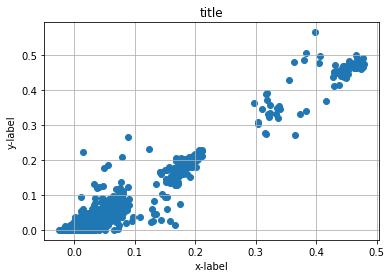

In [107]:
# Visualize the data
plt.figure()
plt.scatter(predictions,y_test)
plt.grid(True)
plt.title("title")
plt.xlabel("x-label")
plt.ylabel("y-label")
plt.show()

In [108]:
# calculate Pearson's correlation
li = []
for i in np.arange(predictions.shape[1]):
    corr, _ = pearsonr(predictions[i],y_test[i])
    li.append(corr)
# Calcuate the mean Pearson's correlation
corr_mean = np.mean(li)
print('Mean Pearsons correlation: %.3f' % corr_mean)

Mean Pearsons correlation: 0.965
